In [19]:
# import basic libraries
import sys
import os
import subprocess

# logic to accomodate Google Colab
try:
    import google.colab

    ENV_IS_CL = True
    root = r"/content/t-route"
    subprocess.run(["git", "clone", "https://github.com/NOAA-OWP/t-route.git"])
    sys.path.append("/content/t-route/src/python_framework_v02")
    sys.path.append("/content/t-route/src/python_framework_v01")

    ! pip install geopandas
    ! pip install netcdf4

    # change current working directory to /notebooks
    os.chdir("/content/t-route/notebooks")
    
except:
    ENV_IS_CL = False
    root = os.path.dirname(os.path.abspath(""))
    sys.path.append(r"../src/python_framework_v02")
    sys.path.append(r"../src/python_framework_v01")

# load needed scientific libraries
from functools import partial
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter, deque
from itertools import chain
import requests
import zipfile
import io
import us

# turn off warnings
import warnings
warnings.simplefilter("ignore")

# import t-route functions for network analysis
import nhd_io
import nhd_network
import network_dl
import nhd_network_utilities_v02 as nnu

In [59]:
print("Identifying supernetwork connections set")

test_folder = os.path.join(root, r"test")
geo_input_folder = os.path.join(test_folder, r"input", r"geo")
supernetwork = 'CapeFear_FULL_RES'

network_data = nnu.set_supernetwork_data(
    supernetwork=supernetwork, geo_input_folder=geo_input_folder
)

# if the NHDPlus RouteLink file does not exist, download it.
if not os.path.exists(network_data["geo_file_path"]):
    filename = os.path.basename(network_data["geo_file_path"])
    network_dl.download(network_data["geo_file_path"], network_data["data_link"])
    
# select only the necessary columns of geospatial data, set the DataFrame index
cols = [v for c, v in network_data.items() if c.endswith("_col")]
data = nhd_io.read(network_data["geo_file_path"])
data = data[cols]
data = data.set_index(network_data["key_col"])

# mask NHDNetwork to isolate test network of choice
if "mask_file_path" in network_data:
    data_mask = nhd_io.read_mask(
        network_data["mask_file_path"],
        layer_string=network_data["mask_layer_string"],
    )
    data = data.filter(data_mask.iloc[:, network_data["mask_key"]], axis=0)

# sort index
data = data.sort_index()

# replace downstreams
data = nhd_io.replace_downstreams(data, network_data['downstream_col'], 0)

# extract downstream connections for each node
connections = nhd_network.extract_connections(data, network_data["downstream_col"])

print("supernetwork connections set created.")

Identifying supernetwork connections set
supernetwork connections set created.


In [61]:
print("Organizing segments into reaches.")

# reverse the network - track upstream connections
rconn = nhd_network.reverse_network(connections)

# isolate independent subnetworks
subnets = nhd_network.reachable_network(rconn)

# identify the segments in each subnetwork
subreachable = nhd_network.reachable(rconn)

# break each subnetwork into reaches 
subreaches = {}
for tw, net in subnets.items():
    path_func = partial(nhd_network.split_at_junction, net)
    subreaches[tw] = nhd_network.dfs_decomposition(net, path_func)  

print("Reach creation complete.")    

Organizing segments into reaches.
Reach creation complete.


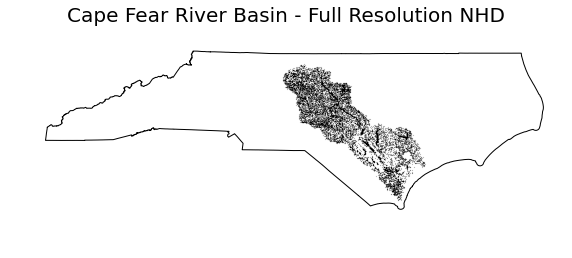

In [62]:
# create a GeoDataFrame for viz purposes
gdf = gpd.GeoDataFrame(dat_geo, geometry=gpd.points_from_xy(dat_geo.lon, dat_geo.lat))

# download North Carolina shapefile for basemap
shape_url = us.states.NC.shapefile_urls()["state"]
local_path = '../test/input/geo/NorthCarolina_state_shape'

# Download and extract shapefile
r = requests.get(shape_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path=local_path)

# get extracted filenames
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
dbf, prj, shp, shx = [filename for filename in filenames]

# load shapefile with GeoPandas
nc = gpd.read_file(local_path + "/" + shp)

# create a basemap
base = nc.plot(
    color="white", edgecolor="black"
)

# add our stream network, segments are represented as small points (nodes in the network)
gdf.plot(ax=base, markersize=0.01, color="black")

# crop the map extent
base.set_xlim(-85, -75)
base.set_ylim(33, 37)

base.axis("off")

fig = plt.gcf()
fig.set_size_inches(10, 15)

# add a title and display
plt.title("Cape Fear River Basin - Full Resolution NHD", fontsize=20)

plt.show()

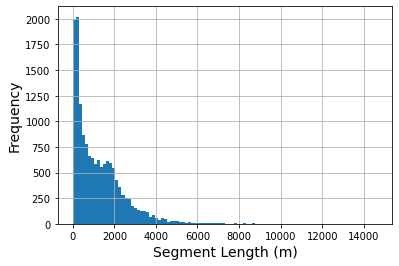

In [57]:
# create a histogram of segment lengths
data.Length.hist(bins = 100)

ax = plt.gca()
ax.set_ylabel("Frequency", size = 14)
ax.set_xlabel("Segment Length (m)", size = 14)

plt.show()

In [79]:
# specify threshold length
thresh = 1000 # meters

short_segs = len(data[data.Length <= thresh].index)
total_segs = len(data.index)

print("There are %s segments in the supernetwork shorter than the threshold length." % (short_segs))
print("That is %s%% of all segments in the supernetwork!" % round(short_segs/total_segs * 100))

There are 8028 segments in the supernetwork shorter than the threshold length.
That is 53% of all segments in the supernetwork!


In [97]:
# loop through each subnetwork
for twi, (tw, reach) in enumerate(subreaches.items(), 1):
    
    # loop through each reach in the subnetwork
    for seg in reach:
        
        # extract segment lengths
        seg_len = data.loc[seg].Length
        
        # which segments are shorter than the threshold?
        short_segs = seg_len[seg_len < thresh].index
        
        print(data.loc[short_segs].Length)

Series([], Name: Length, dtype: float32)
Series([], Name: Length, dtype: float32)
Series([], Name: Length, dtype: float32)
Series([], Name: Length, dtype: float32)
Series([], Name: Length, dtype: float32)
Series([], Name: Length, dtype: float32)
Series([], Name: Length, dtype: float32)
Series([], Name: Length, dtype: float32)
Series([], Name: Length, dtype: float32)
Series([], Name: Length, dtype: float32)
link
8838470    331.0
Name: Length, dtype: float32
Series([], Name: Length, dtype: float32)
Series([], Name: Length, dtype: float32)
link
8832432    511.0
Name: Length, dtype: float32
link
8832440    744.0
Name: Length, dtype: float32
Series([], Name: Length, dtype: float32)
link
8832658    21.0
Name: Length, dtype: float32
Series([], Name: Length, dtype: float32)
link
8832556    879.0
Name: Length, dtype: float32
Series([], Name: Length, dtype: float32)
Series([], Name: Length, dtype: float32)
link
8832424    828.0
Name: Length, dtype: float32
Series([], Name: Length, dtype: float32